#Implementación de un modelo de deep learning

##Procesamiento de datos

Introducción

Este proyecto busca resolver el problema de clasificación de diferentes tipos de zapatos en cinco categorías: Ballet Flat, Boat, Brogue, Clog y Sneaker. Esta clasificación es útil para aplicaciones como sistemas de recomendación de productos, organización automática de inventarios y análisis visual para tiendas en línea.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomRotation, RandomZoom, Dropout, BatchNormalization, ActivityRegularization, RandomFlip, RandomContrast, RandomHeight, RandomBrightness, RandomWidth, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

Usamos un dataset llamado “Shoes Classification Dataset,” que tiene alrededor de 13,000 imágenes de zapatos en cinco categorías. Cada tipo de zapato cuenta con unas 2,000 imágenes para entrenar el modelo. Este dataset ya está dividido en conjuntos de entrenamiento y validación. Antes de entrenar el modelo, las imágenes se normalizan para que los valores de los píxeles estén en un rango adecuado.

In [2]:
import os
from google.colab import files

# Cargar el archivo kaggle.json
files.upload()

# Crear el directorio .kaggle y mover kaggle.json ahí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Descargar el dataset de zapatos
!kaggle datasets download -d utkarshsaxenadn/shoes-classification-dataset-13k-images

# Extraer el contenido del archivo zip
!unzip shoes-classification-dataset-13k-images.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: Shoes Dataset/Train/Clog/Clog-Train (549).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (55).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (550).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (551).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (552).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (553).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (554).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (555).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (556).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (557).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (558).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (559).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (56).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (560).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (561).jpeg  
  inf

In [4]:
!ls /content

 sample_data   shoes-classification-dataset-13k-images.zip  'Shoes Dataset'


El dataset ya venía dividido en entrenamiento, test y validación por lo que facilitó un poco el proceso de separación.

In [5]:
ruta_train = '/content/Shoes Dataset/Train'
ruta_test = '/content/Shoes Dataset/Test'
ruta_valid = '/content/Shoes Dataset/Valid'
IMAGE_SIZE = 128
BATCH_SIZE = 32

Convierte el dataset en un formato el cual el modelo acepta

In [6]:
# Cargar el conjunto de datos de imágenes y convertirlos en arreglos numpy
def load_dataset_as_arrays(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    images = []
    labels = []
    class_names = dataset.class_names

    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels, class_names


Se asignan las etiquetas a sus respectivas fotografías

In [7]:
# Cargar los datos de entrenamiento, validación y prueba
train_images, train_labels, class_names = load_dataset_as_arrays(ruta_train)
test_images, test_labels, _ = load_dataset_as_arrays(ruta_test)
val_images, val_labels, _ = load_dataset_as_arrays(ruta_valid)

Found 10000 files belonging to 5 classes.
Found 1215 files belonging to 5 classes.
Found 2500 files belonging to 5 classes.


In [8]:
# Convertir etiquetas a formato categórico
train_labels = to_categorical(train_labels, num_classes=len(class_names))
test_labels = to_categorical(test_labels, num_classes=len(class_names))
val_labels = to_categorical(val_labels, num_classes=len(class_names))

##Primer modelo CNN

Este código define una arquitectura de red neuronal convolucional (CNN) para clasificación de imágenes en varias clases de calzado. La red utiliza el modelo Sequential de Keras, que facilita la construcción de modelos capa por capa. Primero, se aplican capas de convolución (Conv2D) con activación ReLU para extraer características importantes de las imágenes. Cada capa de convolución va seguida de una capa de MaxPooling2D, que reduce la dimensionalidad y hace que el modelo se enfoque en las características más relevantes. Se añaden capas de Dropout para evitar el sobreajuste apagando algunas neuronas aleatoriamente durante el entrenamiento. Después de las capas convolucionales, BatchNormalization estandariza los valores de activación, lo que acelera y estabiliza el proceso de entrenamiento. La capa Flatten convierte las características en un vector unidimensional, que luego pasa por dos capas densas (Dense) con activación ReLU para procesar las características extraídas. Finalmente, la última capa Dense usa la activación softmax para asignar probabilidades a cada clase de calzado, permitiendo la clasificación.

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Ajustar la salida al número de clases
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 899,909 (3.43 MB)

 Trainable params: 899,653 (3.43 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
acc = tf.keras.metrics.CategoricalAccuracy()

In [11]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=[acc])


In [12]:
history = model.fit(x=train_images, y=train_labels, validation_split=0.1, batch_size=32, epochs=50)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - categorical_accuracy: 0.2811 - loss: 1.6203 - val_categorical_accuracy: 0.1960 - val_loss: 4.2898
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.3857 - loss: 1.4879 - val_categorical_accuracy: 0.3580 - val_loss: 1.5201
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - categorical_accuracy: 0.4583 - loss: 1.3890 - val_categorical_accuracy: 0.3360 - val_loss: 1.9003
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - categorical_accuracy: 0.5091 - loss: 1.3043 - val_categorical_accuracy: 0.4330 - val_loss: 1.4603
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - categorical_accuracy: 0.5812 - loss: 1.1970 - val_categorical_accuracy: 0.2790 - val_loss: 2.5985
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - categorical_accuracy: 0.6443 - loss: 1.1094 - val_categorical_accuracy: 0.4700 - val_loss: 1.3503
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - categorical_accuracy: 0

###Resultados del modelo

In [13]:
history_df = pd.DataFrame(history.history)
history_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.314111,1.566533,0.196,4.289814
1,0.394444,1.467845,0.358,1.520138
2,0.465556,1.382318,0.336,1.900318
3,0.522222,1.286990,0.433,1.460330
4,0.583889,1.197015,0.279,2.598461
5,0.640778,1.103325,0.470,1.350350
6,0.688778,1.012043,0.468,1.394979
7,0.747222,0.922503,0.626,1.177938
8,0.803889,0.817582,0.615,1.207696
9,0.844111,0.744930,0.648,1.176671


En la siguiente gráfica, esta muestra cómo el error en el entrenamiento (línea azul) y en la validación (línea naranja) disminuye a lo largo de las épocas. La pérdida en el entrenamiento baja rápidamente y luego se estabiliza, indicando que el modelo está aprendiendo bien. La pérdida de validación también desciende, aunque con más fluctuaciones, lo que es común debido a la variabilidad en los datos de validación.

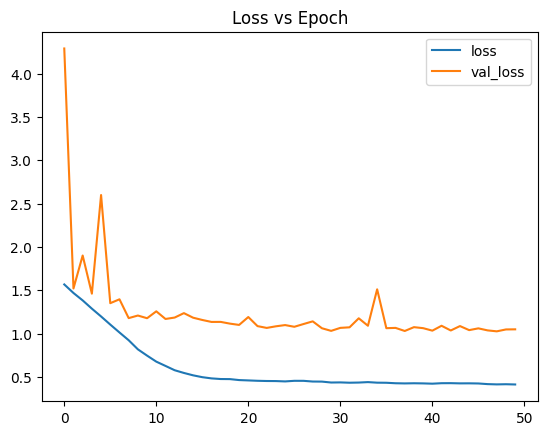

In [14]:
history_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
plt.show()

En la siguiente gráfica, vemos cómo la precisión del modelo mejora tanto en el entrenamiento como en la validación. La precisión en el entrenamiento aumenta hasta cerca de 1, mientras que la precisión de validación se estabiliza en un nivel más bajo, sugiriendo que el modelo podría estar sobreajustando un poco y que se podrían probar algunos ajustes para mejorar el rendimiento en validación.

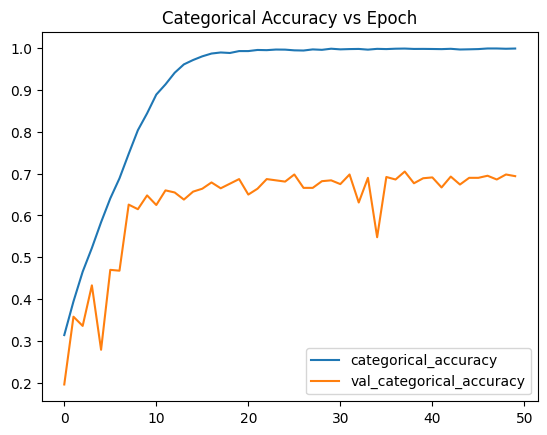

In [15]:
history_df.plot(y=["categorical_accuracy", "val_categorical_accuracy"], title="Categorical Accuracy vs Epoch")
plt.show()

El siguiente bloque de código evalúa el rendimiento del modelo en el conjunto de prueba. La función model.evaluate calcula la pérdida y la precisión del modelo usando las imágenes y etiquetas de prueba. En este caso, la pérdida obtenida es de aproximadamente 1.24 y la precisión es de 0.63, lo que significa que el modelo clasifica correctamente alrededor del 63% de las imágenes en el conjunto de prueba. Aunque el modelo ha aprendido a distinguir las clases en cierto grado, hay margen para mejorar su precisión.

In [16]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.6013 - loss: 1.2442
Loss: 1.20
Accuracy: 0.63


###Predicciones

Los siguientes bloques de código son con la finalidad de poder predecir una imagen, es decir poner en practica el modelo. Muestra una imagen con su etiqueta y la predicción del modelo, seguido de unas graficas que describen el desepeño del modelo y su matriz de confución.

In [57]:
# Seleccionar una imagen de prueba aleatoria y mostrar predicción
random_index = np.random.choice(test_images.shape[0])
test_image = test_images[random_index]

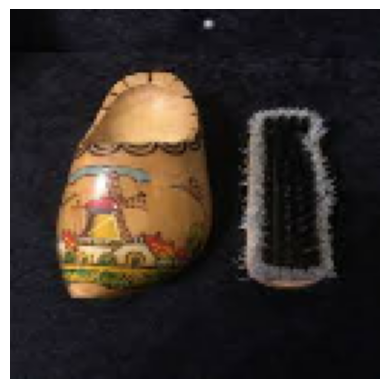

True Label: Clog


In [18]:
plt.axis('off')
plt.imshow(test_image.astype("uint8"))
plt.show()
print("True Label:", class_names[np.argmax(test_labels[random_index])])

In [19]:
# Obtener las predicciones del modelo
pred = model.predict(test_image[np.newaxis, ...])
predicted_class = class_names[np.argmax(pred)]
print("Model Prediction:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Prediction: Brogue


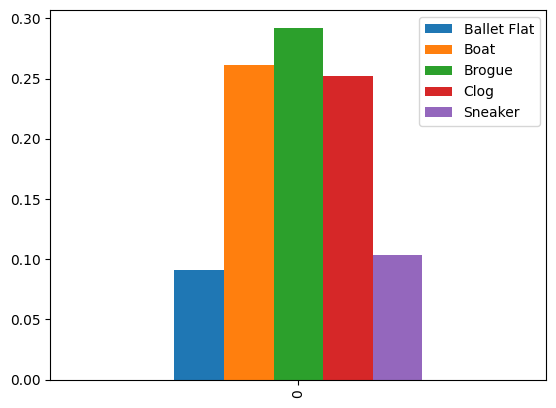

In [20]:
# Ver las predicciones para cada clase
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df.plot.bar()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


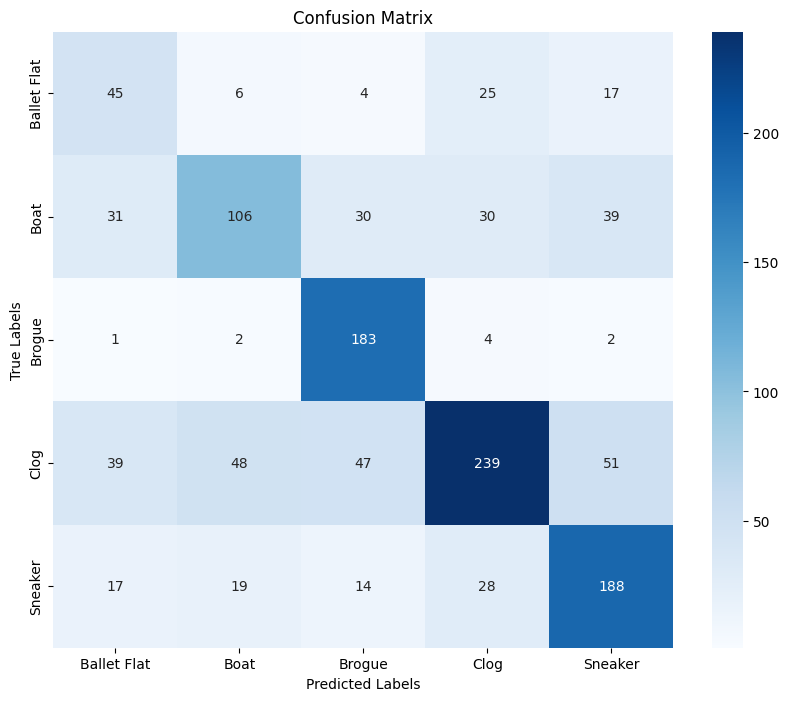

In [21]:
# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

La matriz de confusión muestra que el modelo clasifica bien las clases Brogue y Clog, con 183 y 239 predicciones correctas respectivamente, lo que indica que el modelo identifica estos tipos de zapatos con mayor precisión. Sin embargo, existen errores significativos de clasificación en las clases Boat y Sneaker, especialmente con confusión entre Boat y Clog. La clase Ballet Flat también presenta baja precisión, con varias imágenes clasificadas incorrectamente como Boat o Clog.

En resumen, aunque el modelo logra un buen desempeño en algunas clases, la confusión entre ciertos tipos de zapatos sugiere que podría beneficiarse de un ajuste adicional en las características que diferencian entre clases similares.

##Segundo modelo CNN

Este segundo modelo, model2, incorpora varios cambios para mejorar el rendimiento del modelo inicial. Primero, se añadieron técnicas de data augmentation como zoom, rotación, volteo horizontal y ajuste de contraste. Estas técnicas ayudan a crear más variedad en los datos de entrenamiento, lo cual debería hacer que el modelo sea más adaptable al reconocer los distintos tipos de zapatos en situaciones diferentes.

Además, se aumentó la complejidad del modelo con más filtros en las capas convolucionales, que ahora capturan detalles más específicos de cada imagen. También se agregaron mecanismos para evitar el sobreajuste, como Dropout y la regularización L2, que ayudan a que el modelo no se “memorice” los datos de entrenamiento y, en cambio, aprenda a generalizar mejor. Con estas mejoras, el modelo debería ser capaz de clasificar los tipos de zapatos con más precisión y mayor consistencia en diferentes conjuntos de datos.

In [22]:
model2 = keras.Sequential([
    # Data Augmentation Ajustado
    RandomZoom(0.1),
    RandomRotation(0.2),
    RandomFlip("horizontal"),
    RandomContrast(0.1),

    Conv2D(16, kernel_size=3, padding='same', activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(2),

    Conv2D(32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Dropout(0.2),

    Conv2D(64, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0005)),
    MaxPooling2D(2),
    Dropout(0.2),

    Conv2D(64, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0005)),
    MaxPooling2D(2),
    BatchNormalization(),

    Conv2D(128, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.3),

    # Nueva capa Conv2D para mayor profundidad
    Conv2D(256, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.6),  # Aumento de Dropout en la última capa densa

    Dense(len(class_names), activation='softmax')
])

model2.build((None, IMAGE_SIZE, IMAGE_SIZE, 3))  # None indica un tamaño de lote flexible
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_zoom (RandomZoom)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 563,685 (2.15 MB)

 Trainable params: 562,533 (2.15 MB)

 Non-trainable params: 1,152 (4.50 KB)

En los siguientes bloques de código se implementan varias técnicas para optimizar el proceso de entrenamiento del modelo. Primero, se define el optimizador Adam con una tasa de aprendizaje de 0.0005, lo cual permite que el modelo ajuste sus pesos de manera eficiente en cada iteración. También se define la métrica de precisión categórica, que nos ayudará a evaluar el desempeño del modelo durante y después del entrenamiento.

Luego, se configuran tres callbacks para mejorar los resultados. ReduceLROnPlateau ajusta la tasa de aprendizaje automáticamente cuando el rendimiento en validación deja de mejorar, ayudando a que el modelo converja de manera más estable. EarlyStopping detiene el entrenamiento si no hay mejoras en la pérdida de validación después de varias épocas, evitando el sobreajuste. Finalmente, ModelCheckpoint guarda el mejor modelo durante el entrenamiento, asegurando que tengamos la mejor versión posible basada en el desempeño de validación. Estos callbacks se integran en el entrenamiento de model2, que se ejecuta durante 50 épocas con un tamaño del batch de 64, usando datos de entrenamiento y validación.

In [23]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [26]:
model2.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=[acc])

In [27]:
history2 = model2.fit(
    x=train_images, y=train_labels,
    validation_data=(val_images, val_labels),
    batch_size=64, epochs=50,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - categorical_accuracy: 0.2309 - loss: 3.4735 - val_categorical_accuracy: 0.1788 - val_loss: 2.4129 - learning_rate: 5.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - categorical_accuracy: 0.2409 - loss: 2.8802 - val_categorical_accuracy: 0.2064 - val_loss: 2.4568 - learning_rate: 5.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - categorical_accuracy: 0.2531 - loss: 2.6312 - val_categorical_accuracy: 0.2308 - val_loss: 2.5142 - learning_rate: 5.0000e-04
Epoch 4/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.2585 - loss: 2.4569
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - categorical_accuracy: 0.2585 - loss: 2.4565 - val_categorical_accuracy: 0.2300 - val_loss: 2.4565 - learning_rate: 5.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - categorical_accuracy: 0.2686 - loss: 2.3647 - val_categ

###Resultados del segundo modelo

In [28]:
history2_df = pd.DataFrame(history2.history)
history2_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss,learning_rate
0,0.2422,3.255041,0.1788,2.412884,0.000500
1,0.2451,2.813395,0.2064,2.456758,0.000500
2,0.2562,2.590833,0.2308,2.514209,0.000500
3,0.2592,2.425777,0.2300,2.456494,0.000500
4,0.2658,2.352355,0.2076,2.384000,0.000250
5,0.2843,2.293609,0.2136,2.386341,0.000250
6,0.2877,2.251072,0.2136,2.350447,0.000250
7,0.2926,2.213406,0.2240,2.328666,0.000250
8,0.2960,2.172518,0.2304,2.320012,0.000250
9,0.3109,2.136394,0.2312,2.258214,0.000250


En este segundo modelo, se observa una disminución continua en la pérdida tanto en los datos de entrenamiento como en los datos de validación a lo largo de las épocas, lo que indica una mejora en el ajuste del modelo durante el entrenamiento. Sin embargo, al evaluar el modelo en los datos de prueba, obtuvo una precisión de alrededor de 0.41, con una pérdida de 1.65, lo cual es significativamente menor en comparación con el primer modelo.

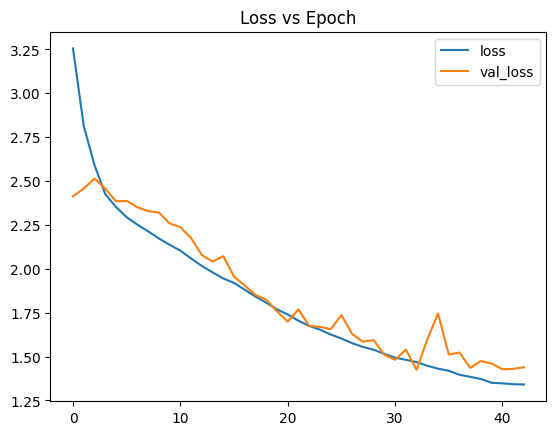

In [29]:
history2_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
plt.show()

Esta caída en el rendimiento puede estar relacionada con la complejidad añadida en la arquitectura y el uso de técnicas de regularización más fuertes, como el aumento de capas de convolución y la introducción de más capas de dropout. Aunque estas técnicas ayudan a reducir el sobreajuste, en este caso pueden haber afectado la capacidad del modelo para generalizar en los datos de prueba.


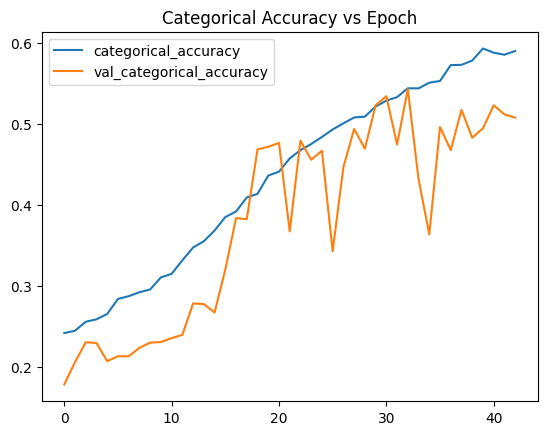

In [30]:
history2_df.plot(y=["categorical_accuracy", "val_categorical_accuracy"], title="Categorical Accuracy vs Epoch")
plt.show()

In [31]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model2.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.4048 - loss: 1.6716
Loss: 1.65
Accuracy: 0.41


###Predicciones del segudo modelo

Los siguientes bloques de código son con la finalidad de poder predecir una imagen, es decir poner en practica el modelo. Muestra una imagen con su etiqueta y la predicción del modelo, seguido de unas graficas que describen el desepeño del modelo y su matriz de confución.

In [32]:
# Seleccionar una imagen de prueba aleatoria y mostrar predicción
random_index = np.random.choice(test_images.shape[0])
test_image = test_images[random_index]

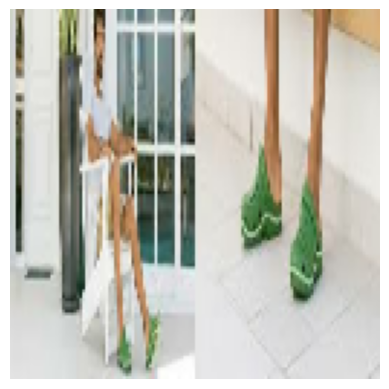

True Label: Clog


In [33]:
plt.axis('off')
plt.imshow(test_image.astype("uint8"))
plt.show()
print("True Label:", class_names[np.argmax(test_labels[random_index])])

In [34]:
# Obtener las predicciones del modelo
pred = model.predict(test_image[np.newaxis, ...])
predicted_class = class_names[np.argmax(pred)]
print("Model Prediction:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Model Prediction: Clog


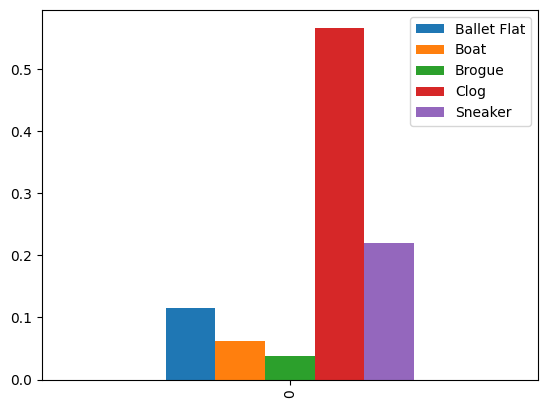

In [35]:
# Ver las predicciones para cada clase
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df.plot.bar()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


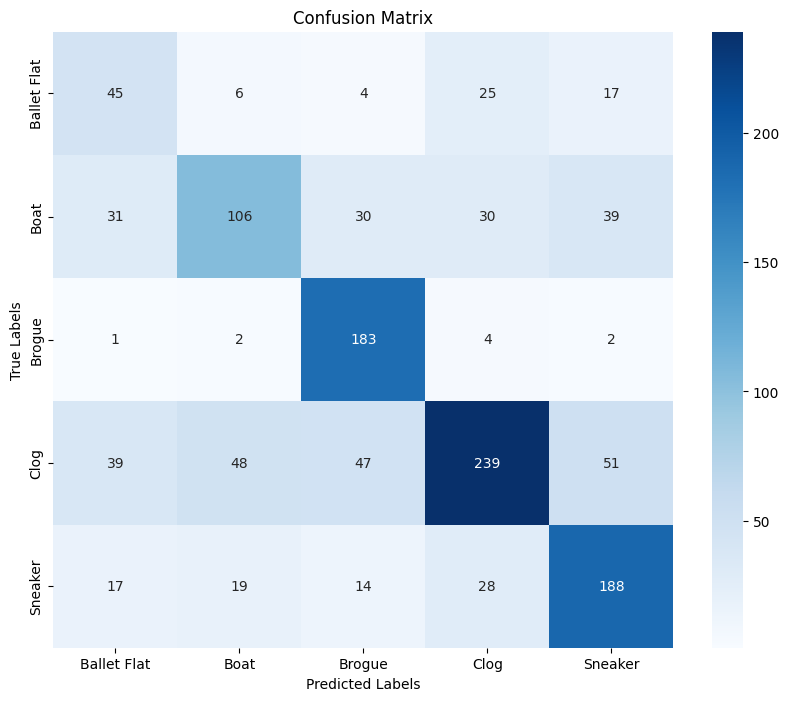

In [36]:
# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

##Tercer modelo

El tercer modelo incorpora ajustes significativos en comparación con los modelos anteriores. En esta nueva arquitectura, se puso una capa de Global Average Pooling al final de las capas convolucionales, lo que ayuda a reducir el número de parámetros y a evitar el sobreajuste al enfocarse en características de mayor nivel en lugar de solo en pixeles individuales. También se ha añadido una regularización L2 de mayor valor en las capas densas finales y una capa adicional de Batch Normalization, lo cual debería estabilizar el entrenamiento y hacer el modelo más robusto ante variaciones en los datos.

En comparación, este tercer modelo ayuda al sobreajuste observados en los modelos anteriores, donde la pérdida en el conjunto de entrenamiento disminuía más rápidamente que en la validación. Al incorporar una mayor regularización y nuevas estrategias de pooling, este modelo debería, en teoría, superar a los dos primeros en precisión y reducción de la pérdida, especialmente en clases con alta confusión en modelos previos.

A pesar de estos cambios nota una mejora significativa :)

In [37]:
model3 = Sequential([
    Conv2D(16, kernel_size=3, padding='same', activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(2),

    Conv2D(32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Dropout(0.2),

    Conv2D(64, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0005)),
    MaxPooling2D(2),
    Dropout(0.2),

    Conv2D(64, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0005)),
    MaxPooling2D(2),
    BatchNormalization(),

    Conv2D(128, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.3),

    # Nueva capa Conv2D para mayor profundidad
    Conv2D(256, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,699,217 (10.30 MB)

 Trainable params: 899,653 (3.43 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,799,308 (6.86 MB)

En el tercer modelo, se cambió el optimizador a RMSprop con una tasa de aprendizaje de 0.0005, lo cual ayuda a gestionar mejor los ajustes en modelos más complejos como este. Además, se mantienen los callbacks de ReduceLROnPlateau, EarlyStopping y ModelCheckpoint, que son cruciales para controlar el proceso de entrenamiento. ReduceLROnPlateau ajusta dinámicamente la tasa de aprendizaje si la pérdida de validación no mejora, EarlyStopping detiene el entrenamiento para evitar sobreajuste, y ModelCheckpoint guarda el mejor modelo basado en la pérdida de validación.

Estas modificaciones, en combinación con los ajustes de arquitectura del modelo, buscan mejorar la estabilidad y precisión en el conjunto de validación. La tasa de aprendizaje más baja y el optimizador RMSprop deberían permitir una convergencia más suave, ayudando a que el modelo no se estanque en mínimos locales, especialmente cuando se entrenan modelos con una mayor cantidad de parámetros y regularización, como en este caso.

In [38]:
opt = RMSprop(learning_rate=0.0005)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_69.keras', monitor='val_loss', save_best_only=True)

history3 = model3.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - categorical_accuracy: 0.2266 - loss: 2.9691 - val_categorical_accuracy: 0.2124 - val_loss: 2.6964 - learning_rate: 5.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - categorical_accuracy: 0.2830 - loss: 2.5268 - val_categorical_accuracy: 0.2768 - val_loss: 2.3922 - learning_rate: 5.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - categorical_accuracy: 0.3368 - loss: 2.2843 - val_categorical_accuracy: 0.3312 - val_loss: 2.1883 - learning_rate: 5.0000e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - categorical_accuracy: 0.3791 - loss: 2.1258 - val_categorical_accuracy: 0.2884 - val_loss: 2.4715 - learning_rate: 5.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - categorical_accuracy: 0.4310 - loss: 1.9670 - val_categorical_accuracy: 0.3372 - val_loss: 2.1865 - learning_rate: 5.0000e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - categorical_accuracy: 0.4744 - loss: 1.

In [39]:
history3_df = pd.DataFrame(history3.history)
history3_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss,learning_rate
0,0.2437,2.800534,0.2124,2.696430,0.000500
1,0.2903,2.473614,0.2768,2.392163,0.000500
2,0.3430,2.248658,0.3312,2.188276,0.000500
3,0.3966,2.073877,0.2884,2.471519,0.000500
4,0.4408,1.929169,0.3372,2.186491,0.000500
5,0.4816,1.800781,0.2944,2.267780,0.000500
6,0.5165,1.674543,0.4152,1.846169,0.000500
7,0.5548,1.577393,0.5808,1.524130,0.000500
8,0.5855,1.473936,0.5600,1.559027,0.000500
9,0.6082,1.389802,0.4780,1.690896,0.000500


Los resultados de este modelo muestra mejoras en comparación con el segundo modelo en cuanto a la precisión final en los datos de prueba, alcanzando una precisión de 0.68 frente a 0.41 del modelo anterior. Las gráficas de pérdida y precisión indican una disminución más estable y consistente en la pérdida, y un aumento más progresivo en la precisión.

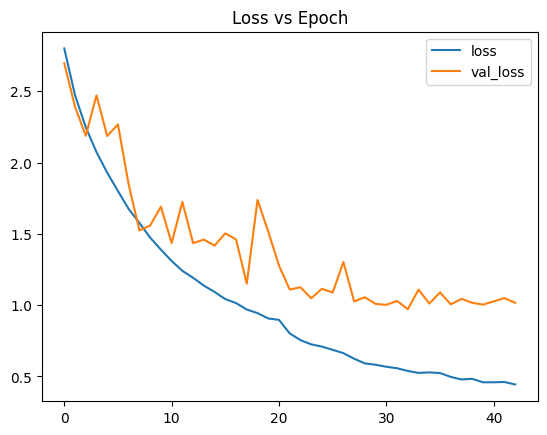

In [63]:
history3_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
plt.show()

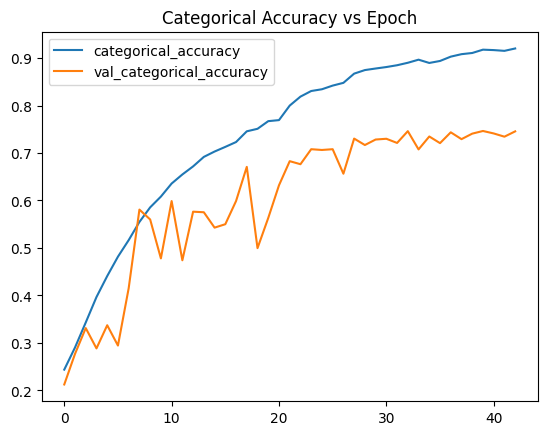

In [41]:
history3_df.plot(y=["categorical_accuracy", "val_categorical_accuracy"], title="Categorical Accuracy vs Epoch")
plt.show()

In [42]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model3.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - categorical_accuracy: 0.6579 - loss: 1.2173
Loss: 1.19
Accuracy: 0.68


###Predicciones

Los siguientes bloques de código son con la finalidad de poder predecir una imagen, es decir poner en practica el modelo. Muestra una imagen con su etiqueta y la predicción del modelo, seguido de unas graficas que describen el desepeño del modelo y su matriz de confución.

In [43]:
# Seleccionar una imagen de prueba aleatoria y mostrar predicción
random_index = np.random.choice(test_images.shape[0])
test_image = test_images[random_index]

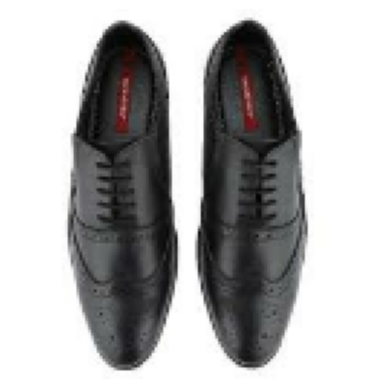

True Label: Brogue


In [44]:
plt.axis('off')
plt.imshow(test_image.astype("uint8"))
plt.show()
print("True Label:", class_names[np.argmax(test_labels[random_index])])

In [45]:
# Obtener las predicciones del modelo
pred = model.predict(test_image[np.newaxis, ...])
predicted_class = class_names[np.argmax(pred)]
print("Model Prediction:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Model Prediction: Brogue


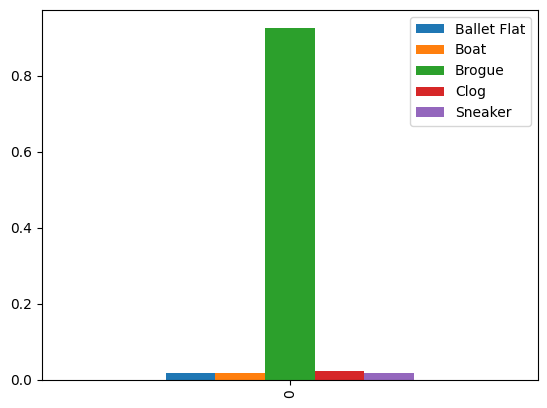

In [46]:
# Ver las predicciones para cada clase
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df.plot.bar()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


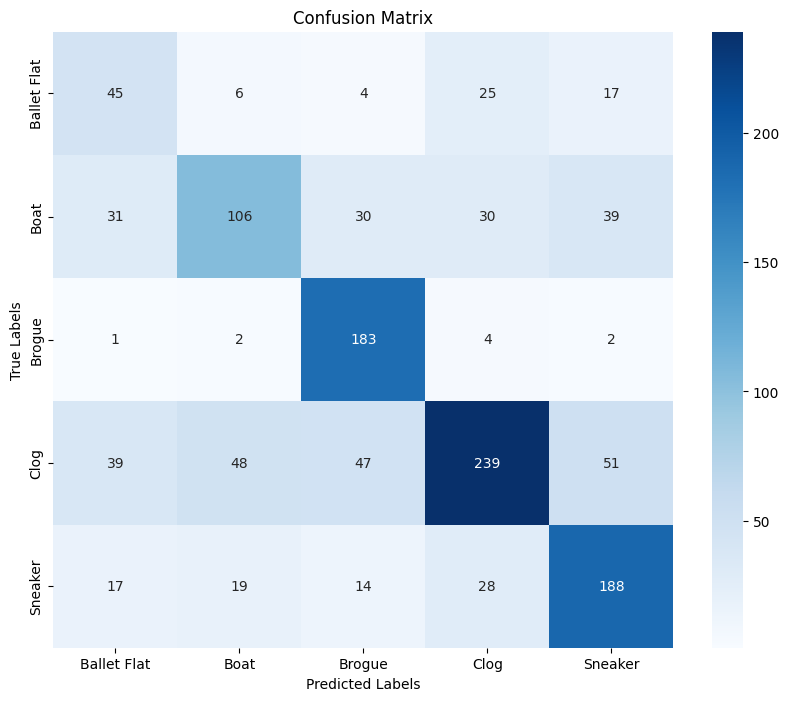

In [47]:
# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

##Cuarto

Este modelo utiliza una arquitectura optimizada con capas Conv2D y MaxPooling2D similares al tercer modelo, pero incluye regularización L2 en todas las capas densas y convolucionales clave para reducir el sobreajuste. Además, el modelo aplica Dropout en niveles del 30% y 40% para mejorar la generalización y se configuraron los callbacks EarlyStopping y ReduceLROnPlateau.

Comparando con el tercer modelo, se mantuvieron las técnicas de regularización, pero este diseño esta más enfocado en evitar el sobreajuste.

In [48]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')  # Ajustar la salida al número de clases
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history4 = model4.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - categorical_accuracy: 0.2499 - loss: 2.3665 - val_categorical_accuracy: 0.1984 - val_loss: 2.3742 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - categorical_accuracy: 0.2804 - loss: 2.1359 - val_categorical_accuracy: 0.2148 - val_loss: 2.2229 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - categorical_accuracy: 0.3052 - loss: 2.0244 - val_categorical_accuracy: 0.2236 - val_loss: 2.0994 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - categorical_accuracy: 0.3301 - loss: 1.9318 - val_categorical_accuracy: 0.2160 - val_loss: 2.2462 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - categorical_accuracy: 0.3672 - loss: 1.8339 - val_categorical_accuracy: 0.2260 - val_loss: 2.1175 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.4069 - loss: 1.7415 - val_categ

In [49]:
history4_df = pd.DataFrame(history4.history)
history4_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss,learning_rate
0,0.2633,2.276245,0.1984,2.374225,0.001000
1,0.2833,2.102090,0.2148,2.222885,0.001000
2,0.3102,1.996356,0.2236,2.099396,0.001000
3,0.3397,1.902132,0.2160,2.246177,0.001000
4,0.3750,1.818962,0.2260,2.117545,0.001000
5,0.4131,1.726043,0.2728,2.256177,0.001000
6,0.4603,1.640379,0.4868,1.660030,0.001000
7,0.4985,1.558286,0.4344,1.628728,0.001000
8,0.5385,1.468056,0.5200,1.531497,0.001000
9,0.5649,1.426823,0.5148,1.591978,0.001000


Los resultados muestran que este modelo alcanzó una precisión de 0.69 en el conjunto de prueba, la cual es una mejora notable con respecto a los modelos anteriores, siendo el mejor de los otros 3. Las gráficas de pérdida y precisión confirman que el modelo ha mantenido una estabilidad durante el entrenamiento, con menos variaciones en la pérdida de validación en comparación con modelos previos.

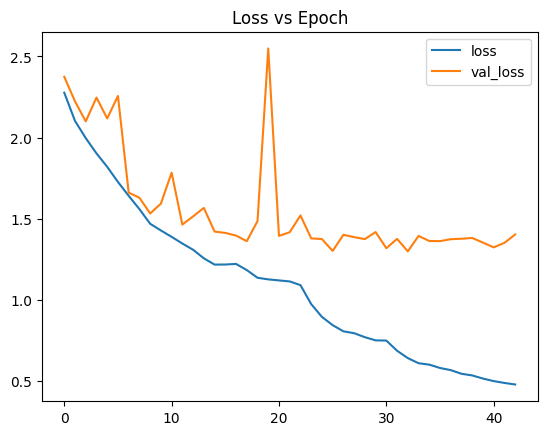

In [50]:
history4_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
plt.show()

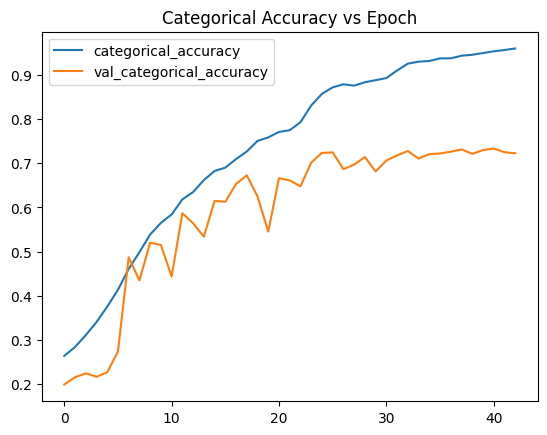

In [51]:
history4_df.plot(y=["categorical_accuracy", "val_categorical_accuracy"], title="Categorical Accuracy vs Epoch")
plt.show()

In [52]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model4.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - categorical_accuracy: 0.6796 - loss: 1.6249
Loss: 1.55
Accuracy: 0.69


###Predicciones

Los siguientes bloques de código son con la finalidad de poder predecir una imagen, es decir poner en practica el modelo. Muestra una imagen con su etiqueta y la predicción del modelo, seguido de unas graficas que describen el desepeño del modelo y su matriz de confución.

In [52]:
# Seleccionar una imagen de prueba aleatoria y mostrar predicción
random_index = np.random.choice(test_images.shape[0])
test_image = test_images[random_index]

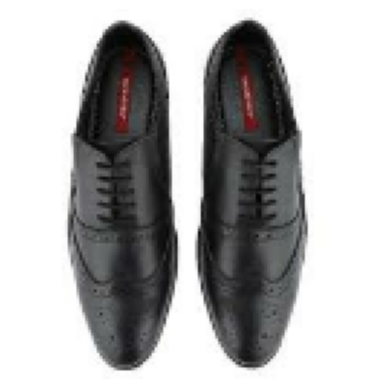

True Label: Brogue


In [53]:
plt.axis('off')
plt.imshow(test_image.astype("uint8"))
plt.show()
print("True Label:", class_names[np.argmax(test_labels[random_index])])

In [59]:
# Obtener las predicciones del modelo
pred = model4.predict(test_image[np.newaxis, ...])
predicted_class = class_names[np.argmax(pred)]
print("Model Prediction:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Prediction: Clog


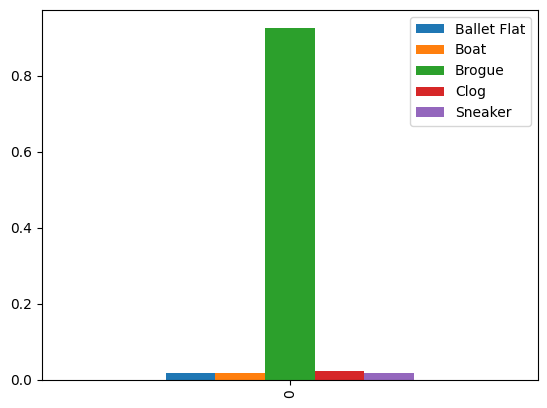

In [55]:
# Ver las predicciones para cada clase
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df.plot.bar()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


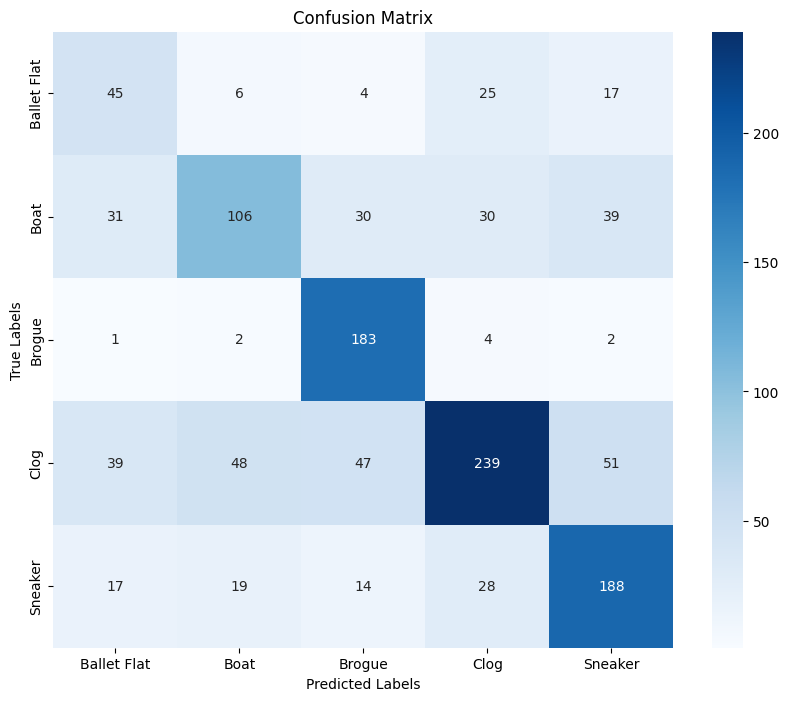

In [56]:
# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [61]:
from google.colab import files
files.download('best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Conclusiones

Esto sugiere que en el futuro podríamos explorar más ajustes en la arquitectura o utilizar un dataset más grande paEn conclusión, los ajustes en el modelo 4 lograron mejorar la precisión en la clasificación de imágenes de zapatos, alcanzando un 69% de precisión en los datos de prueba. Al aplicar técnicas como regularización, aumento de datos y ajustes en la estructura de capas, se obtuvo una mejora significativa en el rendimiento.

In [62]:
# un saludo profe :)